# Project Phoenix Autocallable - Pricing & Hedging under Heston model

**Author :** Baptiste SOREL
$\newline$ **Date :** February 2026


## Section 1: Heston Model & the parameters

To accurately price a path-dependent exotic product like the Phoenix Autocallable, the standard Black-Scholes model is insufficient. Black-Scholes assumes constant volatility, failing to capture the "Volatility Smile" and "Skew" observed in real markets.

For this project, I implemented the Heston Model. Unlike Black-Scholes, Heston assumes that volatility itself is a random process. This allows for a more realistic modeling of market risks, particularly the probability of hitting downside barriers ("Fat Tails").

$
dS_t = \mu S_t dt +\sqrt{v_t}S_t dW_t
\\ dv_t = \kappa (\theta -v_t)dt + \sigma \sqrt{v_t} dZ_t
$
\\ Where the Brownian motions $dW_t$ and $dZ_t$ have correlation $\rho$. The key parameters are : 
- $\kappa$ : mean reversion speed
- $\theta$ : Long term average variance (mean reversion)
- $\sigma$ : volatility of volatility
- $\rho$ : Correlation between the asset price and its volatility. In equity, it is generally negative, creating the skew. As the underlying is the S&P500 (SPY), it is the case here.
- $v_0$ : Initial variance

### Note on calibration

In a live trading environment, these parameters are "calibrated" to fit the market prices of vanilla options (Calls and Puts).
I tried to develop a calibration engine (available in `src/Models/calibration.py`) using the Gil-Pelaez Fourier transform method combined with a least-squares minimization algorithm (scipy.optimize) to minimize the error between the model and market data fetched from Yahoo Finance.

However, the calibration didn't worked properly. Due to data granularity issues and the instability of the optimization process on free data, the automated calibration yielded unstable results. To prioritize the stability of the Pricing and Hedging simulation (the core of this project), I chose to fix the parameters to realistic market values (e.g., $\rho = -0.7$ for S&P 500 behavior) rather than relying on an unstable calibration output.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


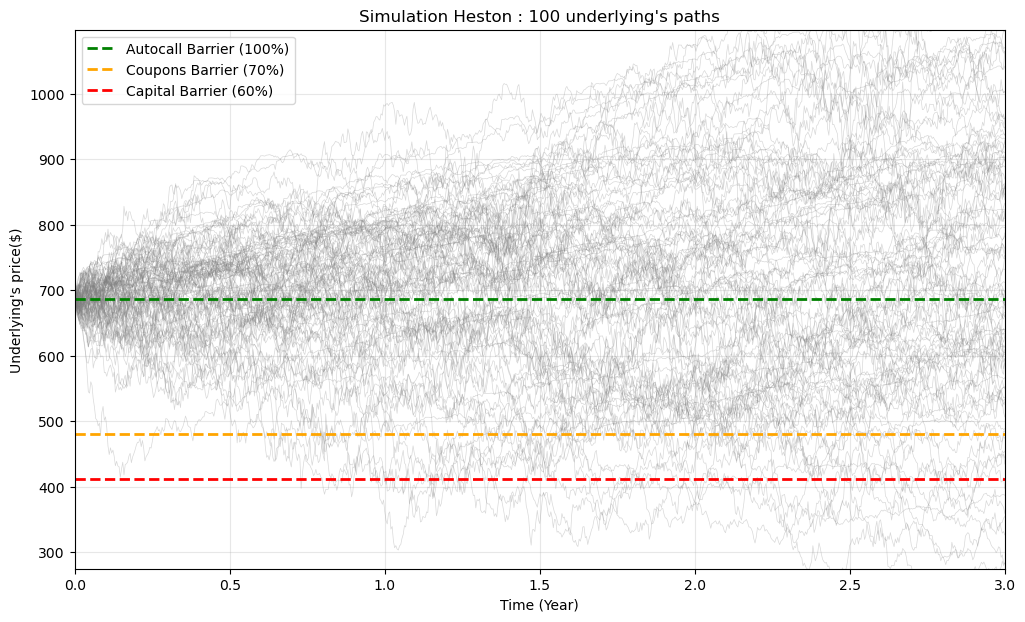

In [76]:
%load_ext autoreload
%autoreload 2

from src.Models import calibration
from src.Models.Heston import HestonModel
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)

nb_paths_to_plot=100
S0=calibration.S0
N_year=252
r=calibration.r 
T=calibration.T
N=10**4
model=HestonModel(kappa=calibration.kappa,theta=calibration.theta,sigma=calibration.sigma,rho=calibration.rho,v0=calibration.v0,S0=S0,r=r,T=T)

total_steps=int(T*N_year)
paths=model.simulate_paths(N,total_steps)
subset_paths=paths[:, :nb_paths_to_plot]

time_axis=np.linspace(0, T, subset_paths.shape[0])

plt.figure(figsize=(12, 7))
plt.plot(time_axis, subset_paths, color='grey', alpha=0.3, linewidth=0.5)
    
plt.axhline(y=calibration.barrier_autocall * S0, color='green', linestyle='--', linewidth=2, label=f'Autocall Barrier ({calibration.barrier_autocall*100:.0f}%)')
plt.axhline(y=calibration.barrier_coupon * S0, color='orange', linestyle='--', linewidth=2, label=f'Coupons Barrier ({calibration.barrier_coupon*100:.0f}%)')
plt.axhline(y=calibration.barrier_capital * S0, color='red', linestyle='--', linewidth=2, label=f'Capital Barrier ({calibration.barrier_capital*100:.0f}%)')

plt.title(f"Simulation Heston : {nb_paths_to_plot} underlying's paths")
plt.xlabel("Time (Year)")
plt.ylabel("Underlying's price($)")
plt.xlim(0, T)
plt.ylim(S0 * 0.4, S0 * 1.6) 
    
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

## Section 2: Structuration & Pricing

Here are the parameters for the rest of the project : 
````
ticker=yf.Ticker("SPY")
S0=ticker.history(period="1d")["Close"].iloc[-1] 
r=yf.Ticker("^IRX").history(period="1d")["Close"].iloc[-1] / 100 #The risk-free rate 
T=3
dt=0.25 # Frequency of observations : every quarter
coupon_rate=0.025 # We start with a coupon of 2.5% every quarter
barrier_autocall=1
barrier_coupon=0.7
barrier_capital=0.6
nominal=1000


v0=0.04       # current variance
kappa=2.0     #mean reversion speed
theta=0.04    #Long term variance, mean reversion
sigma=0.5     #vol of the volatility
rho=-0.7      #Correlation between the underlying and its vol
````
The spot price $S_0$ is set to the latest closing price of the SPY ETF (S&P 500 Proxy). 

The rate $r$ is derived from the CBOE Interest Rate 13-Week T-Bill (IRX). This ensures that the discounting and the drift in the Heston model are consistent with the current monetary environment.

We structured a classic Phoenix Autocallable, with a $T=3$ years maturity, an autocallable barrier at $100\%$, a coupon barrier at $70\%$, and a capital barrier at $60\%$. 

Initally, we consider of coupon of $2.5\%$ quarterly ($10\%$), that we may change later if the margin is negative for the seller (the bank). 

In [77]:
from src.Products.phoenix import Phoenix

calibration.coupon_rate=0.025

phoenix=Phoenix(T=T,dt=calibration.dt,coupon_rate=calibration.coupon_rate,barrier_autocall=calibration.barrier_autocall,barrier_coupon=calibration.barrier_coupon,barrier_capital=calibration.barrier_capital,nominal=calibration.nominal)

N=10**4

model=HestonModel(kappa=calibration.kappa,theta=calibration.theta,sigma=calibration.sigma,rho=calibration.rho,v0=calibration.v0,S0=S0,r=r,T=T)

total_steps=int(T*N_year)
paths=model.simulate_paths(N,total_steps)

client_payoffs=phoenix.evaluate_payoffs_prices(paths)[0]
product_prices=phoenix.evaluate_payoffs_prices(paths)[1]

mean_payoffs=np.mean(client_payoffs)
std_payoffs=np.std(client_payoffs)
mean_prices=np.mean(product_prices)
std_prices=np.std(product_prices)

error_margin = 1.96 * (std_prices / np.sqrt(N))


#### RESULTS ########
print("The average price for this product is "+str(mean_prices)+" with a 95% confidence interval : ["+str(mean_prices-error_margin)+","+str(mean_prices+error_margin)+"]")
if mean_prices<calibration.nominal:
    print("Positive margin : "+str(calibration.nominal-mean_prices)+"$")
else:
    print("Negative margin : "+str(calibration.nominal-mean_prices)+"$")

The average price for this product is 1001.9521612422358 with a 95% confidence interval : [999.5563481855952,1004.3479742988764]
Negative margin : -1.9521612422357748$


When pricing with a coupon of 8%, the margin is negative. It is still quite uncertain due to the statistical noise of the Monte Carlo simulation. 

To raise our margin, one can lower our coupon rate. Let's apply `calibration.coupon_rate=0.015`

In [78]:
from src.Products.phoenix import Phoenix

calibration.coupon_rate=0.015

phoenix=Phoenix(T=T,dt=calibration.dt,coupon_rate=calibration.coupon_rate,barrier_autocall=calibration.barrier_autocall,barrier_coupon=calibration.barrier_coupon,barrier_capital=calibration.barrier_capital,nominal=calibration.nominal)

client_payoffs=phoenix.evaluate_payoffs_prices(paths)[0]
product_prices=phoenix.evaluate_payoffs_prices(paths)[1]

mean_payoffs=np.mean(client_payoffs)
std_payoffs=np.std(client_payoffs)
mean_prices=np.mean(product_prices)
std_prices=np.std(product_prices)

error_margin=1.96 * (std_prices / np.sqrt(N))


#### RESULTS ########
print("The average price for this product is "+str(mean_prices)+" with a 95% confidence interval : ["+str(mean_prices-error_margin)+","+str(mean_prices+error_margin)+"]")
if mean_prices<calibration.nominal:
    print("Positive margin : "+str(calibration.nominal-mean_prices)+"$")
else:
    print("Negative margin : "+str(calibration.nominal-mean_prices)+"$")

The average price for this product is 975.8240731160853 with a 95% confidence interval : [973.6951194398372,977.9530267923334]
Positive margin : 24.175926883914713$


We select the 1.5% coupon structure. This +24 margin (2.4% of the notionnal) provides a necessary safety buffer to cover hedging transaction costs.

Let's now plot the distribution of the client's payoff with our product, for $N=10^4$ simulations : 

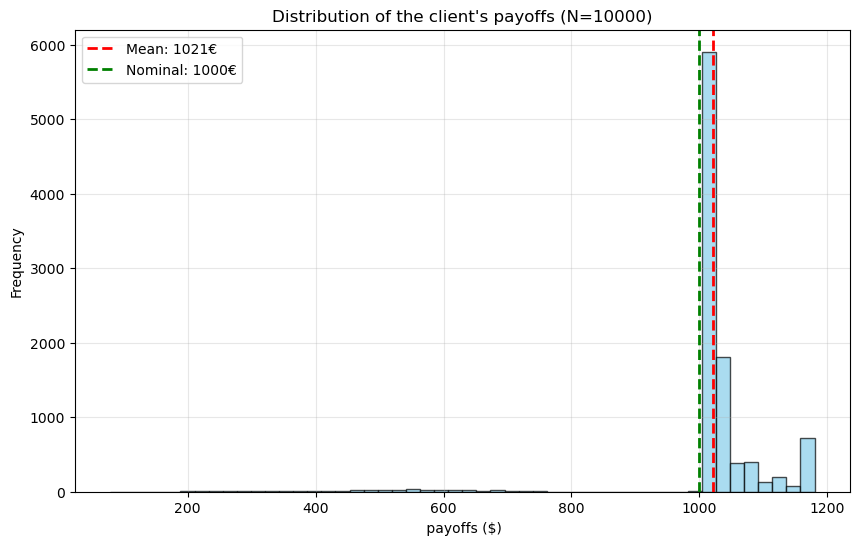

In [79]:
plt.figure(figsize=(10, 6))
plt.hist(client_payoffs, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_payoffs, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_payoffs:.0f}€')
plt.axvline(1000, color='green', linestyle='dashed', linewidth=2, label='Nominal: 1000€')
    
plt.title(f"Distribution of the client's payoffs (N={N})")
plt.xlabel(" payoffs ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The distribution reveals a significant positive asymmetry, with a high concentration of outcomes situated above the Nominal value, corresponding to the frequent Autocall scenarios where the investor receives the capital plus accrued coupons. This structure results in a mean payoff of $1021, indicating a positive expected gross return for the client. However, the long left tail visually captures the downside risk, representing the specific Heston paths where high volatility triggers the capital barrier and erodes the principal.

## Section 3: PnL simulation & Delta hedging

We will now simulate the life of the product, and simulate the PnL of the bank from selling this product. In addition, we will also create a delta neutral portfolio and simulates its PnL.

To do so, as it is not a vanilla product, I estimate the delta of the position as the slope of the product's price with respect to the spot, that is : 

 $$\Delta = \frac{P(S+\epsilon)-P(S)}{\epsilon}$$

 where $\epsilon$ is a small variation of the spot (e.g. $1\% \times S_t$)

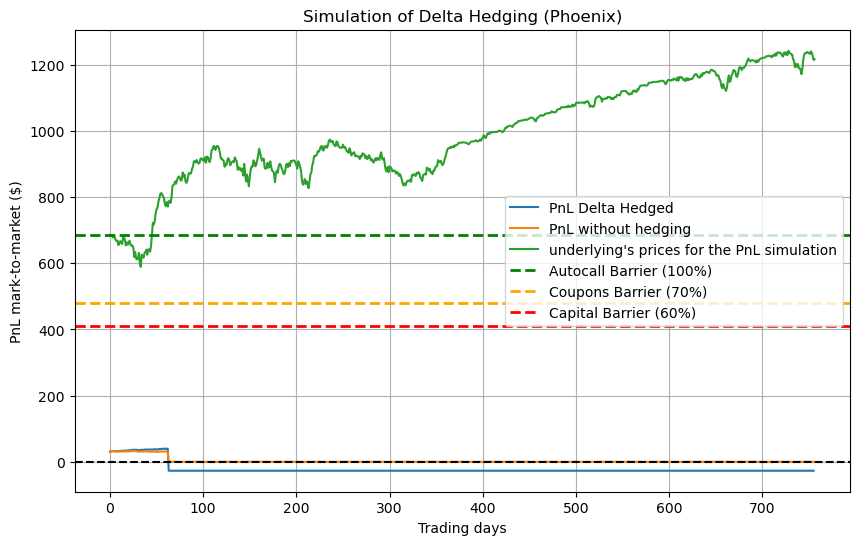

In [80]:
from src.Analytics import pnl_sim

pnl_sim.sim_delta_hedging()

The graph illustrates a scenario where the Autocall mechanism is triggered early (around day 50) due to a sharp rise in the underlying asset.
On this simulation, the delta hedge cannot be observed as the product ends at the first observation . Furthermore, we observe a steady accumulation of profits as the underlying asset rallies toward the barrier. This performance is driven by the Gamma effect (convexity): the portfolio effectively captures value from the significant market moves, allowing the desk to monetize the volatility through dynamic rebalancing. However, the sudden dip at the exact moment of the autocall highlights the residual Gap Risk, where the discontinuity at the barrier creates a swift market move that the discrete hedging frequency cannot perfectly capture.

Let's take a catastrophic scenario to see how the hedge work (with an autocall barrier at 200%) : 


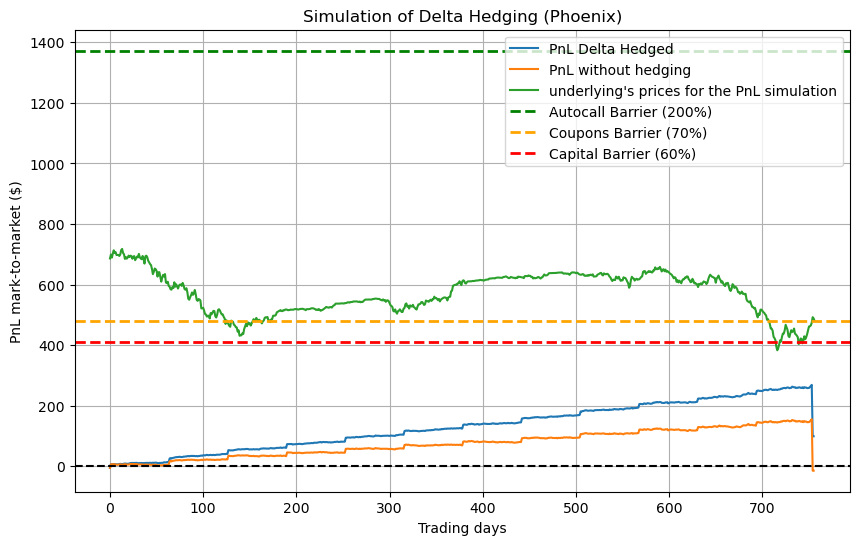

In [81]:
original_barrier=calibration.barrier_autocall
calibration.barrier_autocall=2.0 

np.random.seed(123)

pnl_sim.sim_delta_hedging()

calibration.barrier_autocall=original_barrier

The simulation illustrates a distressed market scenario where the Autocall mechanism is deactivated to observe the product's behavior over its full maturity. The underlying asset (Green line) experiences a severe downturn, breaching the Capital Barrier (60%) towards the end of the period, effectively triggering the Put Down-and-In mechanism. Interestingly, the Unhedged PnL (Orange line) rises significantly; this counter-intuitive result confirms the bank's short position: as the product's value collapses due to the imminent capital loss for the client, the bank's liability decreases, resulting in a profit. Crucially, the Delta-Hedged PnL (Blue line) not only mirrors this trend but outperforms the unhedged position. This additional profit margin is driven by the portfolio's positive convexity (Gamma), allowing the trading desk to monetize the high market volatility by dynamically buying low and selling high during the rebalancing process, ultimately securing a superior risk-adjusted return compared to the naked position.